# Issue Priority Prediction
PRIMO 2022 ML Homework 4 - Kaggle competition (https://www.kaggle.com/competitions/primo-2022-ml-homework-4)

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd
import warnings

from sklearn.feature_extraction import DictVectorizer
import tensorflow as tf

import json

sns.set_theme(style="whitegrid")
warnings.filterwarnings("ignore")
np.set_printoptions(precision=3)
#pd.set_option('precision', 3)

In [56]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [57]:
# Считываем исходные данные
data = pd.read_csv('data/train.csv')

pd.set_option('mode.chained_assignment', None)

print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105365 entries, 0 to 105364
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                105365 non-null  object
 1   summary           105364 non-null  object
 2   description       103548 non-null  object
 3   reporter          105365 non-null  object
 4   created           105365 non-null  int64 
 5   customFields      105365 non-null  object
 6   links             105365 non-null  object
 7   is_high_priority  105365 non-null  bool  
dtypes: bool(1), int64(1), object(6)
memory usage: 5.7+ MB
None


,id,summary,description,reporter,created,customFields,links,is_high_priority
0,25-60681,Don't sync font size within IDEA server plugin,At home I have 1900x1200 resolution and at my ...,"{""login"": ""machak"", ""$type"": ""User""}",1231150644000,"[{""value"": {""name"": ""Bug"", ""$type"": ""EnumBundl...","[{""direction"": ""BOTH"", ""linkType"": {""directed""...",False
1,25-60682,Cancelling subversion update,When cancelling an update from ie. subversion ...,"{""login"": ""sprice"", ""$type"": ""User""}",1231150705000,"[{""value"": {""name"": ""Usability Problem"", ""$typ...","[{""direction"": ""BOTH"", ""linkType"": {""directed""...",False
2,25-60686,Suspended Breakpoint in JVM not Recognized in ...,In some breakpoint cases for a app launched fr...,"{""login"": ""brigham"", ""$type"": ""User""}",1231183948000,"[{""value"": {""name"": ""Bug"", ""$type"": ""EnumBundl...","[{""direction"": ""BOTH"", ""linkType"": {""directed""...",False
3,25-60691,Good code red: IDEA incorrectly resolves neste...,The relevant snippet if part of the UIDebug cl...,"{""login"": ""xduke"", ""$type"": ""User""}",1231241109000,"[{""value"": {""name"": ""Bug"", ""$type"": ""EnumBundl...","[{""direction"": ""BOTH"", ""linkType"": {""directed""...",False
4,25-60679,Module WIll Not Load Jar Dependencies on Intre...,I have IntelliJ 7.0.5 running on both WIndows ...,"{""login"": ""stonemack"", ""$type"": ""User""}",1231133633000,"[{""value"": {""name"": ""Bug"", ""$type"": ""EnumBundl...","[{""direction"": ""BOTH"", ""linkType"": {""directed""...",False


In [58]:
data.drop(columns=['reporter', 'created'], inplace=True)

In [59]:
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105365 entries, 0 to 105364
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                105365 non-null  object
 1   summary           105364 non-null  object
 2   description       103548 non-null  object
 3   customFields      105365 non-null  object
 4   links             105365 non-null  object
 5   is_high_priority  105365 non-null  bool  
dtypes: bool(1), object(5)
memory usage: 4.1+ MB
None


,id,summary,description,customFields,links,is_high_priority
0,25-60681,Don't sync font size within IDEA server plugin,At home I have 1900x1200 resolution and at my ...,"[{""value"": {""name"": ""Bug"", ""$type"": ""EnumBundl...","[{""direction"": ""BOTH"", ""linkType"": {""directed""...",False
1,25-60682,Cancelling subversion update,When cancelling an update from ie. subversion ...,"[{""value"": {""name"": ""Usability Problem"", ""$typ...","[{""direction"": ""BOTH"", ""linkType"": {""directed""...",False
2,25-60686,Suspended Breakpoint in JVM not Recognized in ...,In some breakpoint cases for a app launched fr...,"[{""value"": {""name"": ""Bug"", ""$type"": ""EnumBundl...","[{""direction"": ""BOTH"", ""linkType"": {""directed""...",False
3,25-60691,Good code red: IDEA incorrectly resolves neste...,The relevant snippet if part of the UIDebug cl...,"[{""value"": {""name"": ""Bug"", ""$type"": ""EnumBundl...","[{""direction"": ""BOTH"", ""linkType"": {""directed""...",False
4,25-60679,Module WIll Not Load Jar Dependencies on Intre...,I have IntelliJ 7.0.5 running on both WIndows ...,"[{""value"": {""name"": ""Bug"", ""$type"": ""EnumBundl...","[{""direction"": ""BOTH"", ""linkType"": {""directed""...",False


<b>Общий обзор данных</b>


In [60]:
# размер
print(data.shape)
data[0:1]['links']

(105365, 6)


0    [{"direction": "BOTH", "linkType": {"directed"...
Name: links, dtype: object

In [61]:
for i in data:
  print(len(data[i].unique()))

105365
104674
102645
43395
33536
2


Convert custom fields

In [62]:
def convert_custom_fields(custom_fields_field):
    type_col = ""
    subsystem_col = ""

    for custom_field in (x for y in custom_fields_field for x in y):
        if val := custom_field.get('value'):
            if custom_field.get('name') == 'Type':
                type_col = val.get('name') or ""
            elif custom_field.get('name') == 'Subsystem':
                subsystem_col = val.get('name') or ""

    return {'issueType': type_col, 'subsystem': subsystem_col}

In [63]:
cf_f = data['customFields'].apply(json.loads).to_frame(name='customFields')
converted_cf_f = cf_f.apply(lambda cf: convert_custom_fields(cf), axis='columns', result_type='expand')

In [64]:
data.drop('customFields', axis=1, inplace=True)
data = pd.concat([data, converted_cf_f], axis=1)

Convert links

In [65]:
def convert_links_field(links_field):
    col_dict = {}

    for link_field in (x for y in links_field for x in y):
        direction = link_field['direction']
        how = link_field['linkType']['name']
        col_name = direction + how.replace(" ","")
        col_values = []

        for issue in link_field['issues']:
            issue_id = issue['id']
            col_values.append(issue_id)

        col_dict.update({col_name: " ".join(col_values)})

    return col_dict

In [66]:
links_f = data['links'].apply(json.loads).to_frame(name='links')
converted_links_f = links_f.apply(lambda l: convert_links_field(l), axis='columns', result_type='expand')

In [67]:
data.drop('links', axis=1, inplace=True)
data = pd.concat([data, converted_links_f], axis=1)

In [68]:
data['description'].fillna("", inplace=True)
data['summary'].fillna("", inplace=True)

In [69]:
data = data[["id",
             "BOTHRelates",
             "OUTWARDDepend",
             "INWARDDepend",
             "OUTWARDDuplicate",
             "INWARDDuplicate",
             "OUTWARDSubtask",
             "INWARDSubtask",
             "OUTWARDFolllowed",
             "INWARDFolllowed",
             "BOTHSimilar",
             "BOTHReuse",
             "OUTWARDCause",
             "INWARDCause",
             "OUTWARDLeadsto",
             "INWARDLeadsto",
             "summary",
             "description",
             "issueType",
             "subsystem",
             "is_high_priority"]]

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105365 entries, 0 to 105364
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                105365 non-null  object
 1   BOTHRelates       105365 non-null  object
 2   OUTWARDDepend     105365 non-null  object
 3   INWARDDepend      105365 non-null  object
 4   OUTWARDDuplicate  105365 non-null  object
 5   INWARDDuplicate   105365 non-null  object
 6   OUTWARDSubtask    105365 non-null  object
 7   INWARDSubtask     105365 non-null  object
 8   OUTWARDFolllowed  105365 non-null  object
 9   INWARDFolllowed   105365 non-null  object
 10  BOTHSimilar       105365 non-null  object
 11  BOTHReuse         105365 non-null  object
 12  OUTWARDCause      105365 non-null  object
 13  INWARDCause       105365 non-null  object
 14  OUTWARDLeadsto    105365 non-null  object
 15  INWARDLeadsto     105365 non-null  object
 16  summary           105365 non-null  obj

In [71]:
data

,id,BOTHRelates,OUTWARDDepend,INWARDDepend,OUTWARDDuplicate,INWARDDuplicate,OUTWARDSubtask,INWARDSubtask,OUTWARDFolllowed,INWARDFolllowed,...,BOTHReuse,OUTWARDCause,INWARDCause,OUTWARDLeadsto,INWARDLeadsto,summary,description,issueType,subsystem,is_high_priority
0,25-60681,,,,,,,,,,...,,,,,,Don't sync font size within IDEA server plugin,At home I have 1900x1200 resolution and at my ...,Bug,Core. Project Settings,False
1,25-60682,,,,,,,,,,...,,,,,,Cancelling subversion update,When cancelling an update from ie. subversion ...,Usability Problem,Version Control. Subversion,False
2,25-60686,25-976077,,,,,,,,,...,,,,,,Suspended Breakpoint in JVM not Recognized in ...,In some breakpoint cases for a app launched fr...,Bug,Java. Debugger,False
3,25-60691,,,,,,,,,,...,,,,,,Good code red: IDEA incorrectly resolves neste...,The relevant snippet if part of the UIDebug cl...,Bug,Code Analysis. Inspection,False
4,25-60679,,,,,,,,,,...,,,,,,Module WIll Not Load Jar Dependencies on Intre...,I have IntelliJ 7.0.5 running on both WIndows ...,Bug,Core. Project Settings,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105360,25-2507313,,,,,,,,,,...,,,,,,Version Control Incoming tab missing search fi...,"The Version Control tab for ""Incoming"" doesn't...",Usability Problem,Version Control. Subversion,False
105361,25-2507159,,,,,25-2497655,,,,,...,,,,,,Groovy compiler can't find files with names co...,1. Create a new Project with groovy support\n2...,Bug,,False
105362,25-2507096,,,,,25-435240,,,,,...,,,,,,auto close stepped in files on debug resume,"Hi,\n\none coworker switched from eclipse to I...",Feature,Java. Debugger,False
105363,25-2506900,,,,,25-1833184,,,,,...,,,,,,Keymaps don't resync after disabled settings s...,I had to disable setting sync so I could expor...,Bug,Core. IDE Settings. Sharing,False


Some thing i dont know

In [72]:
id_features = ["id",
               "BOTHRelates",
               "OUTWARDDepend",
               "INWARDDepend",
               "OUTWARDDuplicate",
               "INWARDDuplicate",
               "OUTWARDSubtask",
               "INWARDSubtask",
               "OUTWARDFolllowed",
               "INWARDFolllowed",
               "BOTHSimilar",
               "BOTHReuse",
               "OUTWARDCause",
               "INWARDCause",
               "OUTWARDLeadsto",
               "INWARDLeadsto"
               ]

In [73]:
text_features = ['summary', 'description']

In [74]:
categorical_features = ['issueType', 'subsystem']

In [75]:
expected_features = ['is_high_priority']

In [76]:
inputs_train = data.copy()
inputs_expected = inputs_train.pop('is_high_priority')

In [77]:
inputs = {}
for name, column in inputs_train.items():
    if type(column[0]) == str:
        dtype = tf.string
    elif type(column[0]) == bool or type(column[0]) == np.bool_ :
        dtype = tf.bool
    else:
        print(type(column[0]))
        raise ValueError("Unhandled type")

    inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)
inputs

{'id': <KerasTensor: shape=(None,) dtype=string (created by layer 'id')>,
 'BOTHRelates': <KerasTensor: shape=(None,) dtype=string (created by layer 'BOTHRelates')>,
 'OUTWARDDepend': <KerasTensor: shape=(None,) dtype=string (created by layer 'OUTWARDDepend')>,
 'INWARDDepend': <KerasTensor: shape=(None,) dtype=string (created by layer 'INWARDDepend')>,
 'OUTWARDDuplicate': <KerasTensor: shape=(None,) dtype=string (created by layer 'OUTWARDDuplicate')>,
 'INWARDDuplicate': <KerasTensor: shape=(None,) dtype=string (created by layer 'INWARDDuplicate')>,
 'OUTWARDSubtask': <KerasTensor: shape=(None,) dtype=string (created by layer 'OUTWARDSubtask')>,
 'INWARDSubtask': <KerasTensor: shape=(None,) dtype=string (created by layer 'INWARDSubtask')>,
 'OUTWARDFolllowed': <KerasTensor: shape=(None,) dtype=string (created by layer 'OUTWARDFolllowed')>,
 'INWARDFolllowed': <KerasTensor: shape=(None,) dtype=string (created by layer 'INWARDFolllowed')>,
 'BOTHSimilar': <KerasTensor: shape=(None,) dt

ID text vectorizer

In [78]:
id_encoder = tf.keras.layers.TextVectorization(
    split='whitespace',
)

In [79]:
id_adapt_data = []
for name in id_features:
    print("processing col: " + name)
    col_vals = inputs_train[name].tolist()
    id_adapt_data.extend(col_vals)

#id_adapt_tds = tf.data.Dataset.from_tensor_slices(id_adapt_data)
id_adapt_np = np.array(id_adapt_data)

id_encoder.adapt(id_adapt_np)

processing col: id
processing col: BOTHRelates
processing col: OUTWARDDepend
processing col: INWARDDepend
processing col: OUTWARDDuplicate
processing col: INWARDDuplicate
processing col: OUTWARDSubtask
processing col: INWARDSubtask
processing col: OUTWARDFolllowed
processing col: INWARDFolllowed
processing col: BOTHSimilar
processing col: BOTHReuse
processing col: OUTWARDCause
processing col: INWARDCause
processing col: OUTWARDLeadsto
processing col: INWARDLeadsto


In [80]:
id_encoder.vocabulary_size()

126604

In [81]:
id_model = tf.keras.models.Sequential()
id_model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
id_model.add(id_encoder)
id_model.build((1,))
id_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [82]:
id_model.save('model/id_model', save_format="tf")

INFO:tensorflow:Assets written to: model/id_model\assets


description/summary text vectorizer

In [83]:
desc_summ_encoder = tf.keras.layers.TextVectorization()

In [84]:
desc_summ_data = []
for name in text_features:
    print("processing col: " + name)
    col_vals = inputs_train[name].tolist()
    desc_summ_data.extend(col_vals)

desc_summ_tds = tf.data.Dataset.from_tensor_slices(desc_summ_data)

desc_summ_encoder.adapt(desc_summ_tds)

processing col: summary
processing col: description


In [85]:
desc_summ_encoder.vocabulary_size()

545504

In [86]:
desc_summ_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    desc_summ_encoder
])
desc_summ_model.build((1,))
desc_summ_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, None)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [87]:
desc_summ_model.save('model/desc_summ_model', save_format="tf")

INFO:tensorflow:Assets written to: model/desc_summ_model\assets


## Build model

In [237]:
inp_cats = []
x_cats = []
for name in categorical_features:
    inp_cat = tf.keras.Input(shape=(1,), dtype=tf.string, name=name)

    vocab = sorted(set(data[name]))

    x_cat = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')(inp_cat)

    inp_cats.append(inp_cat)
    x_cats.append(x_cat)

In [238]:
x_cats

[<KerasTensor: shape=(None, 14) dtype=float32 (created by layer 'string_lookup_4')>,
 <KerasTensor: shape=(None, 178) dtype=float32 (created by layer 'string_lookup_5')>]

In [239]:
inp_ids = []
x_ids = []
for id_feature in id_features:
    inp_id = tf.keras.Input(shape=(1,), dtype=tf.string, name=id_feature)
    x_id = id_encoder(inp_id)
    x_id = tf.keras.layers.Embedding(
             input_dim=id_encoder.vocabulary_size() + 1,
             output_dim=4,
             # Use masking to handle the variable sequence lengths
             input_length=1,
             mask_zero=True)(x_id)
    inp_ids.append(inp_id)
    x_ids.append(x_id)

In [240]:
x_ids

[<KerasTensor: shape=(None, None, 4) dtype=float32 (created by layer 'embedding_18')>,
 <KerasTensor: shape=(None, None, 4) dtype=float32 (created by layer 'embedding_19')>,
 <KerasTensor: shape=(None, None, 4) dtype=float32 (created by layer 'embedding_20')>,
 <KerasTensor: shape=(None, None, 4) dtype=float32 (created by layer 'embedding_21')>,
 <KerasTensor: shape=(None, None, 4) dtype=float32 (created by layer 'embedding_22')>,
 <KerasTensor: shape=(None, None, 4) dtype=float32 (created by layer 'embedding_23')>,
 <KerasTensor: shape=(None, None, 4) dtype=float32 (created by layer 'embedding_24')>,
 <KerasTensor: shape=(None, None, 4) dtype=float32 (created by layer 'embedding_25')>,
 <KerasTensor: shape=(None, None, 4) dtype=float32 (created by layer 'embedding_26')>,
 <KerasTensor: shape=(None, None, 4) dtype=float32 (created by layer 'embedding_27')>,
 <KerasTensor: shape=(None, None, 4) dtype=float32 (created by layer 'embedding_28')>,
 <KerasTensor: shape=(None, None, 4) dtype=

In [241]:
x_ids_all = tf.concat(x_ids, axis=1)
print(x_ids_all)
x_ids_all = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x_ids_all)
x_ids_all

KerasTensor(type_spec=TensorSpec(shape=(None, None, 4), dtype=tf.float32, name=None), name='tf.concat_3/concat:0', description="created by layer 'tf.concat_3'")


<KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'bidirectional_2')>

In [242]:
inp_texts = []
x_texts = []
for text_feature in text_features:
    inp_text = tf.keras.Input(shape=(1,), dtype=tf.string, name=text_feature)
    x_text = desc_summ_encoder(inp_text)
    x_text = tf.keras.layers.Embedding(
        input_dim=desc_summ_encoder.vocabulary_size() + 1,
        output_dim=32,
        # Use masking to handle the variable sequence lengths
        input_length=200,
        mask_zero=True)(x_text)
    inp_texts.append(inp_text)
    x_texts.append(x_text)

In [243]:
x_texts

[<KerasTensor: shape=(None, None, 32) dtype=float32 (created by layer 'embedding_34')>,
 <KerasTensor: shape=(None, None, 32) dtype=float32 (created by layer 'embedding_35')>]

In [250]:
x_texts_all = tf.concat(x_texts, axis=1) # tf.keras.layers.Concatenate(axis=2)(x_texts) #
print(x_texts_all)
x_texts_all = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x_texts_all)
x_texts_all

KerasTensor(type_spec=TensorSpec(shape=(None, None, 32), dtype=tf.float32, name=None), name='tf.concat_6/concat:0', description="created by layer 'tf.concat_6'")


<KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'bidirectional_4')>

In [251]:
x_texts_all.shape

TensorShape([None, 64])

In [252]:
all_inputs = []
all_inputs.extend(inp_ids)
all_inputs.extend(inp_texts)
all_inputs.extend(inp_cats)

In [253]:
all_x = [x_ids_all, x_texts_all]
all_x.extend(x_cats)

In [254]:
all_x_tf = tf.concat(all_x, axis=-1)
all_x_tf

<KerasTensor: shape=(None, 320) dtype=float32 (created by layer 'tf.concat_7')>

In [255]:
from keras import regularizers

hidden = tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.001))(all_x_tf)
hidden = tf.keras.layers.Dropout(0.4)(hidden)
hidden = tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=regularizers.l2(0.001))(hidden)
hidden = tf.keras.layers.Dropout(0.4)(hidden)
hidden

<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'dropout_3')>

In [256]:
dense = tf.keras.layers.Dense(1,  activation='sigmoid')(hidden)

In [257]:
model = tf.keras.Model(inputs= all_inputs, outputs= dense)

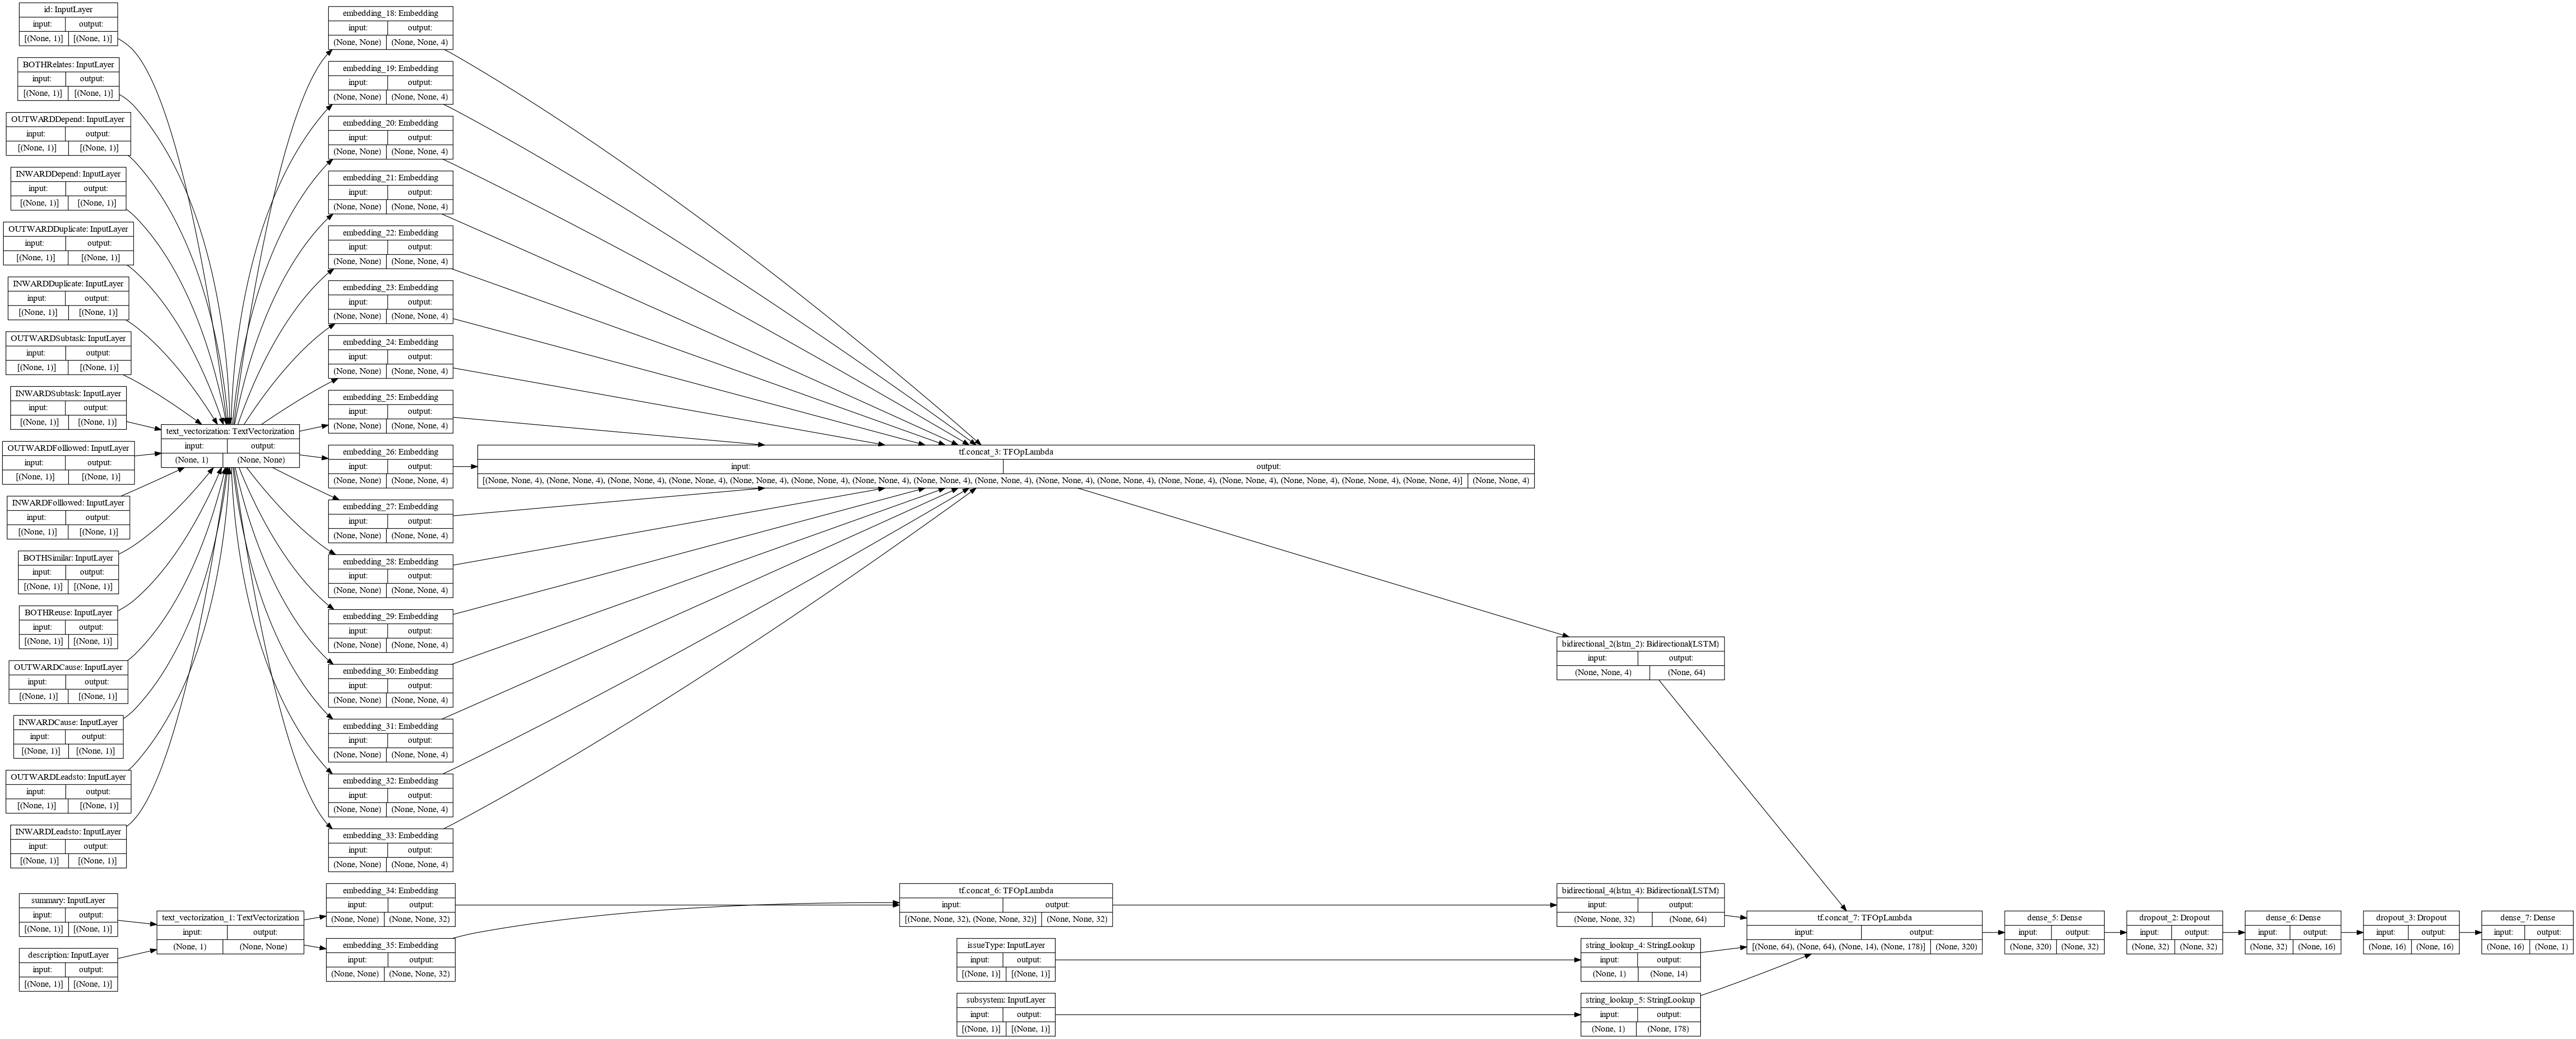

In [302]:
tf.keras.utils.plot_model(model, rankdir="LR", show_shapes=True)

In [259]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [260]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
id (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
BOTHRelates (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
OUTWARDDepend (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
INWARDDepend (InputLayer)       [(None, 1)]          0                                            
____________________________________________________________________________________________

In [261]:
#id_model.save('model/compiled_model', save_format="tf")

In [262]:
from sklearn.model_selection import train_test_split

In [263]:
# Separate the test data
x, x_test, y, y_test = train_test_split(inputs_train, inputs_expected, test_size=0.15, shuffle=True)

In [264]:
# Split the remaining data to train and validation
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, shuffle=True)

In [267]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose = 1)

In [268]:
history = model.fit(x = dict(x_train), y = y_train, batch_size = 16,
                    epochs=8,
                    verbose=2,
                    validation_data=(dict(x_val), y_val),
                    callbacks = [callback])

Epoch 1/8
4758/4758 - 392s - loss: 0.1944 - accuracy: 0.9555 - val_loss: 0.1683 - val_accuracy: 0.9539
Epoch 2/8
4758/4758 - 374s - loss: 0.1092 - accuracy: 0.9561 - val_loss: 0.3184 - val_accuracy: 0.9539
Epoch 00002: early stopping


In [111]:
#mweights = model.get_weights()

In [269]:
model.save('model/final_model_better')

INFO:tensorflow:Assets written to: model/final_model_better\assets


INFO:tensorflow:Assets written to: model/final_model_better\assets


In [270]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
id (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
BOTHRelates (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
OUTWARDDepend (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
INWARDDepend (InputLayer)       [(None, 1)]          0                                            
____________________________________________________________________________________________

## Использование на тестовой выборке

In [271]:
test_df = pd.read_csv('data/test.csv')
test_df.summary.fillna('', inplace=True)
test_df.head()

,id,summary,description,reporter,created,customFields,links
0,25-2512303,WSL support for JVM development under Windows,As a Kotlin/Scala/Java developer on Windows I ...,"{""login"": ""joost.3"", ""$type"": ""User""}",1569949612582,"[{""value"": {""name"": ""Feature"", ""$type"": ""EnumB...","[{""direction"": ""BOTH"", ""linkType"": {""directed""..."
1,25-2513780,Mozilla's Fluent (*.ftl) syntax highlighting,What steps will reproduce the problem?\n\n1. O...,"{""login"": ""tobiaskybernium"", ""$type"": ""User""}",1570088574970,"[{""value"": {""name"": ""Feature"", ""$type"": ""EnumB...","[{""direction"": ""BOTH"", ""linkType"": {""directed""..."
2,25-2515293,Quick definition (Ctrl+Shift+I) called on Lomb...,What steps will reproduce the issue?\n1. Creat...,"{""login"": ""Sergei_Tsypanov"", ""$type"": ""User""}",1570190482389,"[{""value"": {""name"": ""Bug"", ""$type"": ""EnumBundl...","[{""direction"": ""BOTH"", ""linkType"": {""directed""..."
3,25-2514349,Checkboxes in search dialog not aligned to pix...,Ugly checkbox boundaries under windows 10 (per...,"{""login"": ""gamalik"", ""$type"": ""User""}",1570110634652,"[{""value"": {""name"": ""Cosmetics"", ""$type"": ""Enu...","[{""direction"": ""BOTH"", ""linkType"": {""directed""..."
4,25-2514337,HTTP client: Response Handler is not called wh...,**Problem**\n\nI can't use [response handler s...,"{""login"": ""iwansoft"", ""$type"": ""User""}",1570110085315,"[{""value"": {""name"": ""Usability Problem"", ""$typ...","[{""direction"": ""BOTH"", ""linkType"": {""directed""..."


In [272]:
test_df = test_df.drop(['reporter', 'created'], axis=1)

In [273]:
cf_f_test = test_df['customFields'].apply(json.loads).to_frame(name='customFields')
converted_cf_f_test = cf_f_test.apply(lambda cf: convert_custom_fields(cf), axis='columns', result_type='expand')

In [274]:
test_df.drop('customFields', axis=1, inplace=True)
test_df = pd.concat([test_df, converted_cf_f_test], axis=1)

In [275]:
links_f_test = test_df['links'].apply(json.loads).to_frame(name='links')
converted_links_f_test = links_f_test.apply(lambda l: convert_links_field(l), axis='columns', result_type='expand')

In [276]:
test_df.drop('links', axis=1, inplace=True)
test_df = pd.concat([test_df, converted_links_f_test], axis=1)

In [277]:
test_df['description'].fillna("", inplace=True)
test_df['summary'].fillna("", inplace=True)

In [278]:
test_df = test_df[[
            "id",
            "BOTHRelates",
            "OUTWARDDepend",
            "INWARDDepend",
            "OUTWARDDuplicate",
            "INWARDDuplicate",
            "OUTWARDSubtask",
            "INWARDSubtask",
            "OUTWARDFolllowed",
            "INWARDFolllowed",
            "BOTHSimilar",
            "BOTHReuse",
            "OUTWARDCause",
            "INWARDCause",
            "OUTWARDLeadsto",
            "INWARDLeadsto",
            "summary",
            "description",
            "issueType",
            "subsystem"]]

In [279]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18529 entries, 0 to 18528
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                18529 non-null  object
 1   BOTHRelates       18529 non-null  object
 2   OUTWARDDepend     18529 non-null  object
 3   INWARDDepend      18529 non-null  object
 4   OUTWARDDuplicate  18529 non-null  object
 5   INWARDDuplicate   18529 non-null  object
 6   OUTWARDSubtask    18529 non-null  object
 7   INWARDSubtask     18529 non-null  object
 8   OUTWARDFolllowed  18529 non-null  object
 9   INWARDFolllowed   18529 non-null  object
 10  BOTHSimilar       18529 non-null  object
 11  BOTHReuse         18529 non-null  object
 12  OUTWARDCause      18529 non-null  object
 13  INWARDCause       18529 non-null  object
 14  OUTWARDLeadsto    18529 non-null  object
 15  INWARDLeadsto     18529 non-null  object
 16  summary           18529 non-null  object
 17  description 

In [280]:
test_df

,id,BOTHRelates,OUTWARDDepend,INWARDDepend,OUTWARDDuplicate,INWARDDuplicate,OUTWARDSubtask,INWARDSubtask,OUTWARDFolllowed,INWARDFolllowed,BOTHSimilar,BOTHReuse,OUTWARDCause,INWARDCause,OUTWARDLeadsto,INWARDLeadsto,summary,description,issueType,subsystem
0,25-2512303,25-2719410 25-2751307 25-2858706 25-3108818 25...,,,,,,,,,,,,,,,WSL support for JVM development under Windows,As a Kotlin/Scala/Java developer on Windows I ...,Feature,
1,25-2513780,,,,,,,,,,,,,,,,Mozilla's Fluent (*.ftl) syntax highlighting,What steps will reproduce the problem?\n\n1. O...,Feature,Frameworks
2,25-2515293,,,,,,,,,,,,,,,,Quick definition (Ctrl+Shift+I) called on Lomb...,What steps will reproduce the issue?\n1. Creat...,Bug,Frameworks. Lombok
3,25-2514349,,,,,,,,,,,,,,,,Checkboxes in search dialog not aligned to pix...,Ugly checkbox boundaries under windows 10 (per...,Cosmetics,Editor
4,25-2514337,,,,,,,,,,,,,,,,HTTP client: Response Handler is not called wh...,**Problem**\n\nI can't use [response handler s...,Usability Problem,Tools. HTTP Client
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18524,25-3224524,,,,,25-2439065,,,,,,,,,,,Incorrect Error Message Text Decoding of Java ...,Intellij uses incorrect text encoding for disp...,Configuration Problem,
18525,25-3224569,,,,,25-2967377,,,,,,,,,,,Code Style: Spacing for code braces not work,**What steps will reproduce the issue?**\n\n1....,Bug,
18526,25-3224564,,,,,25-2897994,,,,,,,,,,,Diglog is hided by the taskbar when taskbar is...,Intellij IDEA 2020.3.3 \nwindows 10\n\n**What ...,Bug,
18527,25-3224549,,,,,,,,,,,,,,,,"Debugger shall use ""MethodParameters"" attribut...",If there is neither `LocalVariableTable` nor `...,Bug,Java. Debugger


In [ ]:
predictions = {}

In [142]:
test_df_len = len(test_df.index)

In [150]:
hd = dict(test_df[0:11])
hd

{'id': 0     25-2512303
 1     25-2513780
 2     25-2515293
 3     25-2514349
 4     25-2514337
 5     25-2512992
 6     25-2514081
 7     25-2513668
 8     25-2511510
 9     25-2509902
 10    25-2514553
 Name: id, dtype: object,
 'BOTHRelates': 0     25-2719410 25-2751307 25-2858706 25-3108818 25...
 1                                                      
 2                                                      
 3                                                      
 4                                                      
 5                                                      
 6                      25-2747806 25-3153783 25-2241811
 7                                            25-2346435
 8                                                      
 9                                                      
 10                                                     
 Name: BOTHRelates, dtype: object,
 'OUTWARDDepend': 0     
 1     
 2     
 3     
 4     
 5     
 6     
 7     
 8     
 9  

In [281]:
result = []
ix = 0
while ix < test_df_len:
    slice = test_df[ix:ix+10]

    predict_slice = dict(slice)
    res = model.predict(predict_slice)

    res_list = [y for x in np.ndarray.tolist(res) for y in x]

    data_slice = slice['id']

    zipped = list(zip(data_slice,res_list))

    result.extend(zipped)

    ix = ix + 10

In [282]:
result

[('25-2512303', 0.00047771286335773766),
 ('25-2513780', 0.0013389188097789884),
 ('25-2515293', 0.00012349039025139064),
 ('25-2514349', 0.0003370249178260565),
 ('25-2514337', 0.00044418490142561495),
 ('25-2512992', 0.003360573435202241),
 ('25-2514081', 0.4444179832935333),
 ('25-2513668', 0.4076318144798279),
 ('25-2511510', 0.0022530185524374247),
 ('25-2509902', 0.0015591594856232405),
 ('25-2514553', 6.5114043536596e-05),
 ('25-2511118', 0.3565573990345001),
 ('25-2514074', 0.0010145718697458506),
 ('25-2510991', 0.0009564902866259217),
 ('25-2514825', 0.005070971325039864),
 ('25-2511622', 0.0012666693655773997),
 ('25-2514695', 0.4318679869174957),
 ('25-2511429', 0.0018309573642909527),
 ('25-2513557', 0.2603486478328705),
 ('25-2513716', 0.2708859145641327),
 ('25-2512351', 0.0012987488880753517),
 ('25-2513705', 0.42533421516418457),
 ('25-2513221', 0.0035737918224185705),
 ('25-2513733', 0.006031944416463375),
 ('25-2513729', 0.0008440706878900528),
 ('25-2513737', 0.0033

In [293]:
len(result)

18529

In [290]:
import statistics
statistics.mean([x[1] for x in result])

0.0578829211670538

In [288]:
statistics.mode([x[1] for x in result])

0.4444179832935333

In [291]:
max([x[1] for x in result])

0.4444179832935333

In [174]:
result[18528]

('25-3224582', 0.04289416968822479)

In [151]:
res = model.predict(hd)

In [158]:
[y for x in list(res) for y in x]

[0.99936324,
 0.43803155,
 0.99880934,
 0.97497034,
 0.24900849,
 0.84088564,
 0.9999589,
 0.49227476,
 0.83189493,
 0.99847,
 0.003917]

In [160]:
slice = test_df[0:11]['id']

In [161]:
wtf = [y for x in np.ndarray.tolist(res) for y in x]

In [164]:
list(zip(slice, wtf))

[('25-2512303', 0.9993632435798645),
 ('25-2513780', 0.43803155422210693),
 ('25-2515293', 0.9988093376159668),
 ('25-2514349', 0.9749703407287598),
 ('25-2514337', 0.24900849163532257),
 ('25-2512992', 0.8408856391906738),
 ('25-2514081', 0.999958872795105),
 ('25-2513668', 0.49227476119995117),
 ('25-2511510', 0.8318949341773987),
 ('25-2509902', 0.9984700083732605),
 ('25-2514553', 0.003916999790817499)]

In [294]:
res

array([[0.154],
       [0.056],
       [0.105],
       [0.053],
       [0.023],
       [0.012],
       [0.086],
       [0.058],
       [0.093]], dtype=float32)

In [295]:
threshold = 0.25

In [296]:
def prob_to_boolean(flt):
    return 1 if flt > threshold else 0

In [297]:
res_bool = [(x[0], prob_to_boolean(x[1])) for x in result]

In [232]:
import statistics

statistics.mode([(x[1]) for x in result])

0.9999996423721313

In [298]:
res_bool

[('25-2512303', 0),
 ('25-2513780', 0),
 ('25-2515293', 0),
 ('25-2514349', 0),
 ('25-2514337', 0),
 ('25-2512992', 0),
 ('25-2514081', 1),
 ('25-2513668', 1),
 ('25-2511510', 0),
 ('25-2509902', 0),
 ('25-2514553', 0),
 ('25-2511118', 1),
 ('25-2514074', 0),
 ('25-2510991', 0),
 ('25-2514825', 0),
 ('25-2511622', 0),
 ('25-2514695', 1),
 ('25-2511429', 0),
 ('25-2513557', 1),
 ('25-2513716', 1),
 ('25-2512351', 0),
 ('25-2513705', 1),
 ('25-2513221', 0),
 ('25-2513733', 0),
 ('25-2513729', 0),
 ('25-2513737', 0),
 ('25-2514175', 0),
 ('25-2515375', 0),
 ('25-2514755', 0),
 ('25-2516197', 0),
 ('25-2513713', 0),
 ('25-2515665', 0),
 ('25-2511599', 0),
 ('25-2511902', 0),
 ('25-2516122', 1),
 ('25-2515282', 1),
 ('25-2511399', 0),
 ('25-2510150', 0),
 ('25-2513627', 0),
 ('25-2514921', 0),
 ('25-2513709', 1),
 ('25-2513707', 0),
 ('25-2513723', 0),
 ('25-2510712', 1),
 ('25-2510105', 0),
 ('25-2513481', 0),
 ('25-2514820', 0),
 ('25-2514429', 0),
 ('25-2511192', 0),
 ('25-2514059', 0),


In [299]:
res_df = pd.DataFrame.from_records(res_bool, columns=['id','is_high_priority'])

In [300]:
res_df

,id,is_high_priority
0,25-2512303,0
1,25-2513780,0
2,25-2515293,0
3,25-2514349,0
4,25-2514337,0
...,...,...
18524,25-3224524,0
18525,25-3224569,0
18526,25-3224564,0
18527,25-3224549,0


In [301]:
res_df.to_csv('nn-results4.csv',columns=['id', 'is_high_priority'], index=False)

### 3. Объединяем результаты - если кто-то из моделей сказал что задача важная, то считаем её важной

In [42]:
final_result['is_high_priority'] = (final_result['is_high_priority_tree'] > 0).astype(int) 

final_result.to_csv('tree-model-links-and-custom.csv', columns=['id', 'is_high_priority'], index=False)